# Kernel-based Time-varying Regression - Part I

**Kernel-based time-varying regression (KTR)** is a time series model to address

1. time-varying regression coefficients 
2. complex seasonality pattern

The full details of the model structure with an application in marketing media mix modeling can be found in Ng, Wang and Dai (2021). The core of KTR is the use of latent variables to define a smooth time varying representation of model coefficients, which bears a similar ideas in [Kernel Smoothsing](https://en.wikipedia.org/wiki/Kernel_smoother). The KTR approach sharply reduces the number of parameters compared to typical dynamic linear models such as Harvey (1989), and Durbin and Koopman (2002). The reduced number of parameters improves the computation speed, and allows for handling of high dimensional data and detecting small variances.

To topics covered here in **Part I**, are

1. KTR model structure
2. syntax to initialize, fit and predict a model
3. fit a model with complex seasonality
4. visualization of prediction and decomposed components

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import orbit
from orbit.models import KTR
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.utils.dataset import load_electricity_demand

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
print(orbit.__version__)

1.1.4.3


## Model Structure

This section gives the mathematical structure of the KTR model. In short, it considers a time-series ($y_t$) as the linear combination of three parts which are the local-trend ($l_t$), seasonality ($s_t$), and regression ($r_t$) terms. Mathematically,

$$y_t = l_t + s_t + r_t +\epsilon_t,  ~ t = 1,\cdots, T,$$

where the $\epsilon_t$ comprise a stationary random error process.

In **KTR**, the distinction between the local-trend, seasonality, and regressors while useful is semi-arbitrary and the time-series can also be considered as

$$y_t = X_t^T\beta_t + \epsilon_t,  ~ t = 1,\cdots, T,$$

where $\beta_t$ is a $P$-dimensional vector of coefficients that vary over time (i.e., $\beta_i$ is almost certainly different from $\beta_j$ for $i \neq j$) and $X_t$ $P$-dimensional covariate vector (i.e., the $t$th row of $X$, the design matrix).


To reduce the total number of parameters in the model (potentially $P \times T$) the $\beta_t$ are parameterized with a weighted sum of $J$ local latent variables ($b_1,..b_j,..b_J$). That is

$$B = K b^T$$


where
- *coefficient matrix* $B$ has size $T \times P$ with rows equal to the $\beta_t$. 
- *knot matrix* $b$ with size $P\times J$; each entry is a latent variable  $b_{p, j}$. The $b_j$ can be viewed as the "knots" from the perspective of spline regression and $j$ is a time index such that $t_j \in [1, \cdots, T]$.
- *kernel matrix*  $K$  with size $T\times J$ where the $i$th row and $j$th element can be viewed as the normalized weight $k(t_j, t) / \sum_{j=1}^{J} k(t_j, t)$

For the level/trend,

$$l_t = \beta_{t, \text{lev}}$$

It can also be viewed as a dynamic intercept (where the regressor is a vector of ones).

For the seasonality,

$$B_{\text{seas}} = K_{\text{seas}}b^T_{\text{seas}}$$

$$s_t = X_{t, \text{seas}}\beta_{t, \text{seas}}$$

We use Fourier series to handle the seasonality; i.e., sin waves with varying periods are used for the columns of $X_{ \text{seas}}$.

The details for the additional regressors are given in **Part II**, as they are not used in this tutorial.
Note this includes different choices of kernel function (which determines the kernel matrix $K$) and prior for matrix $b$.

## Data

To illustrate the usage of KTR, consider the daily series of electricity demand in Turkey from the 2000 - 2008.

In [3]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()
date_col = 'date'
response_col = 'electricity'
df[response_col] = np.log(df[response_col])
print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.43760
1,2000-01-02,9.50130
2,2000-01-03,9.63565
3,2000-01-04,9.65392
4,2000-01-05,9.66089


In [4]:
print(f'starts with {df[date_col].min()}\nends with {df[date_col].max()}\nshape: {df.shape}')

starts with 2000-01-01 00:00:00
ends with 2008-12-31 00:00:00
shape: (3288, 2)


### Train / Test Split

Split the data into a training set and test set for model validation.

In [5]:
test_size=365
train_df=df[:-test_size]
test_df=df[-test_size:]

## A Quick Start on KTR

Here the Similar to other model types in Orbit, KTR follows sklearn model API style. First an instance of the Orbit class `KTR` is created. Second fit and predict methods are called for that instance. Note that unlike version `<=1.0.15`, the fitting API arg are within the function; thus, `KTR` is called directly. 

In [6]:
ktr = KTR(
    response_col=response_col,
    date_col=date_col,
    seed=2021,
    estimator='pyro-svi',
    # bootstrap sampling to capture uncertainties
    n_bootstrap_draws=1e4,
    # pyro training config
    num_steps=301,
    message=100,
)

In [7]:
ktr.fit(train_df)

2024-01-21 14:13:46 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-01-21 14:13:47 - orbit - INFO - Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
/Users/towinazure/opt/miniconda3/envs/orbit39/lib/python3.9/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
2024-01-21 14:13:47 - orbit - INFO - step    0 loss = -1946.6, scale = 0.093118
INFO:orbit:step    0 loss = -1946.6, scale = 0.093118
2024-01-21 14:13:49 - orbit - INFO - step  100 loss = -3131.7, scale = 0.01002
INFO:orbit:step  100 loss = -3131.7, scale = 0.01002
2024-01-21 14:13:52 - orbit - INFO - step  200 loss = -3119.9, scale = 0.0097664
INFO:orbit:

We can take a look how the level is fitted with the data. 

In [8]:
predicted_df = ktr.predict(df=df)
predicted_df.head()

,date,prediction_5,prediction,prediction_95
0,2000-01-01,9.44892,9.57984,9.71264
1,2000-01-02,9.44500,9.57739,9.70880
2,2000-01-03,9.44493,9.57808,9.70847
3,2000-01-04,9.44703,9.57779,9.70920
4,2000-01-05,9.44381,9.57772,9.71131


One can use `.get_posterior_samples()` to extract the samples for all sampling parameters.

In [9]:
ktr.get_posterior_samples().keys()

dict_keys(['lev_knot', 'lev', 'yhat', 'obs_scale'])

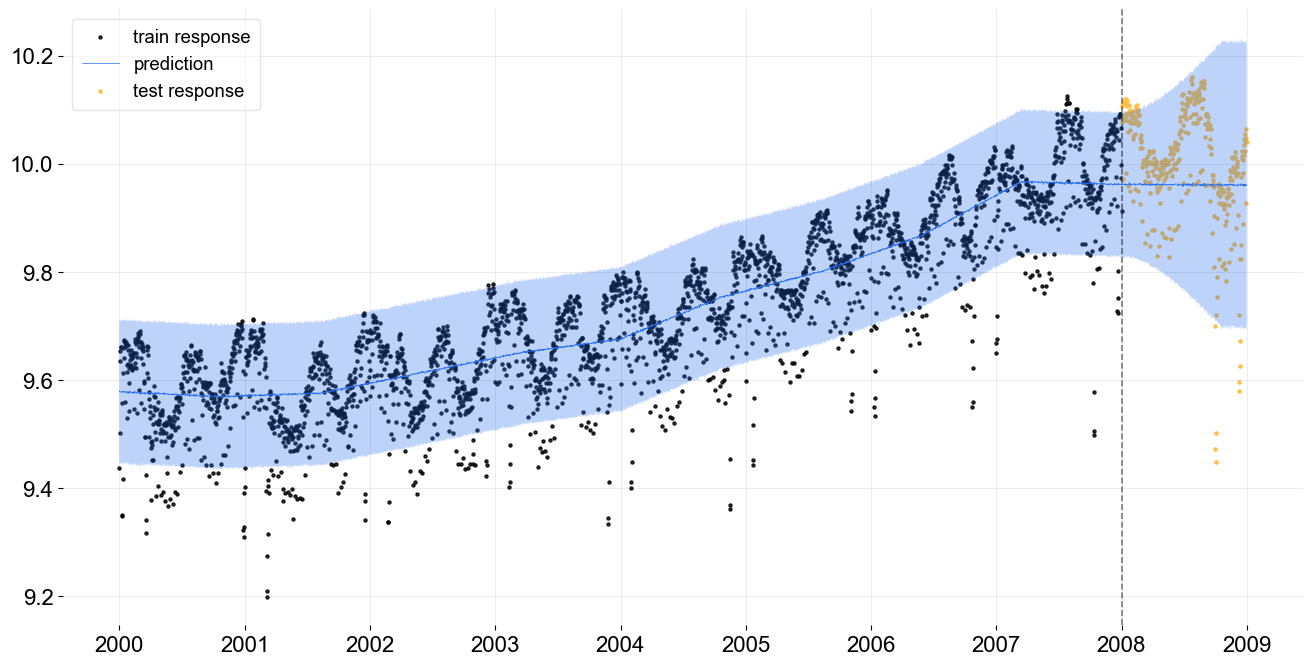

In [10]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                        date_col=date_col, actual_col=response_col, 
                        test_actual_df=test_df, markersize=20, lw=.5)

It can also be helpful to see the trend knot locations and levels. This is done with the `plot_lev_knots` function.

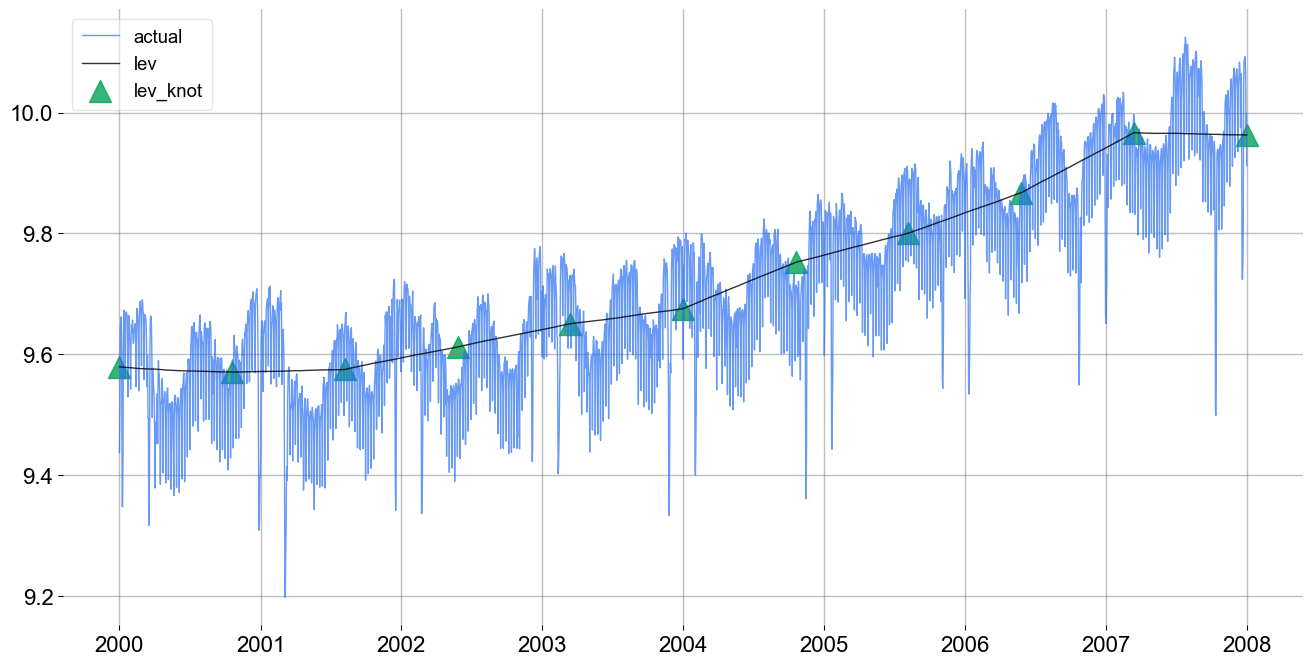

In [11]:
_ = ktr.plot_lev_knots()

## Fitting with Complex Seasonality

The previous model fit is not satisfactory as there is clear seasonality in the electrical demand time-series that is not accounted for. In this modelling example the electrical demand data is fit with a dual seasonality for weekly and yearly patterns. Since the data is daily, the seasonality periods are 7 and 365.25. These are added into the KTR object as a list through the `seasonality` arg. Otherwise the process is the same as the previous example.


In [12]:
ktr_with_seas = KTR(
    response_col=response_col,
    date_col=date_col,
    seed=2021,
    seasonality=[7, 365.25],
    estimator='pyro-svi',
    n_bootstrap_draws=1e4,
    # pyro training config
    num_steps=301,
    message=100,
)

In [13]:
ktr_with_seas.fit(train_df)

2024-01-21 14:13:58 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-01-21 14:13:59 - orbit - INFO - Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
INFO:orbit:Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
2024-01-21 14:13:59 - orbit - INFO - step    0 loss = -2190.8, scale = 0.093667
INFO:orbit:step    0 loss = -2190.8, scale = 0.093667
2024-01-21 14:14:01 - orbit - INFO - step  100 loss = -4356.8, scale = 0.0069845
INFO:orbit:step  100 loss = -4356.8, scale = 0.0069845
2024-01-21 14:14:03 - orbit - INFO - step  200 loss = -4349.7, scale = 0.0073678
INFO:orbit:step  200 loss = -4349.7, scale = 0.0073678
2024-01-21 14:14:05 - orbit - INFO - step  300 loss = -4272.4, scale = 0.0069981
INFO:orbit:step  300 loss = -4272.4, scale = 0.0069981


In [14]:
predicted_df = ktr_with_seas.predict(df=df, decompose=True)

In [15]:
predicted_df.head(5)

,date,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,regression_5,regression,regression_95,seasonality_7_5,seasonality_7,seasonality_7_95,seasonality_365.25_5,seasonality_365.25,seasonality_365.25_95
0,2000-01-01,9.53265,9.61369,9.69614,9.50375,9.58479,9.66724,0.00000,0.00000,0.00000,-0.02784,-0.02784,-0.02784,0.05674,0.05674,0.05674
1,2000-01-02,9.48057,9.56191,9.64390,9.50168,9.58302,9.66501,0.00000,0.00000,0.00000,-0.07872,-0.07872,-0.07872,0.05761,0.05761,0.05761
2,2000-01-03,9.54146,9.62372,9.70469,9.50140,9.58366,9.66463,0.00000,0.00000,0.00000,-0.01838,-0.01838,-0.01838,0.05845,0.05845,0.05845
3,2000-01-04,9.60107,9.68258,9.76360,9.50221,9.58371,9.66474,0.00000,0.00000,0.00000,0.03962,0.03962,0.03962,0.05924,0.05924,0.05924
4,2000-01-05,9.58382,9.66647,9.74869,9.50078,9.58344,9.66565,0.00000,0.00000,0.00000,0.02304,0.02304,0.02304,0.05999,0.05999,0.05999


Tips: there is an additional arg `seasonality_fs_order` to control the number of orders in `fourier series terms` we want to approximate the seasonality.  In general, they cannot violate the condition that $2 \times  \text{fourier series order} < \text{seasonality}$ since each order represents adding a pair of sine and cosine regressors.

## More Diagnostic and Visualization

Here are a few more diagnostic and visualization. The fit is decomposed into components, the local trend and both periods of seasonality.

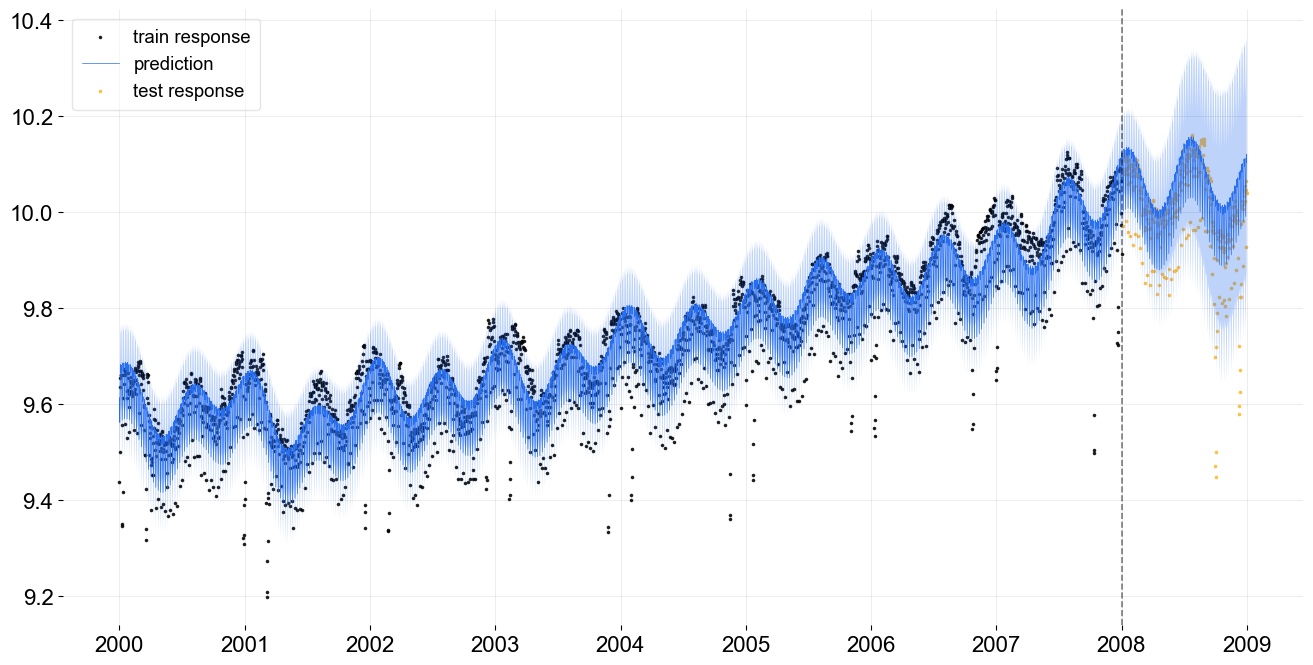

In [16]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                        date_col=date_col, actual_col=response_col, 
                        test_actual_df=test_df, markersize=10, lw=.5)

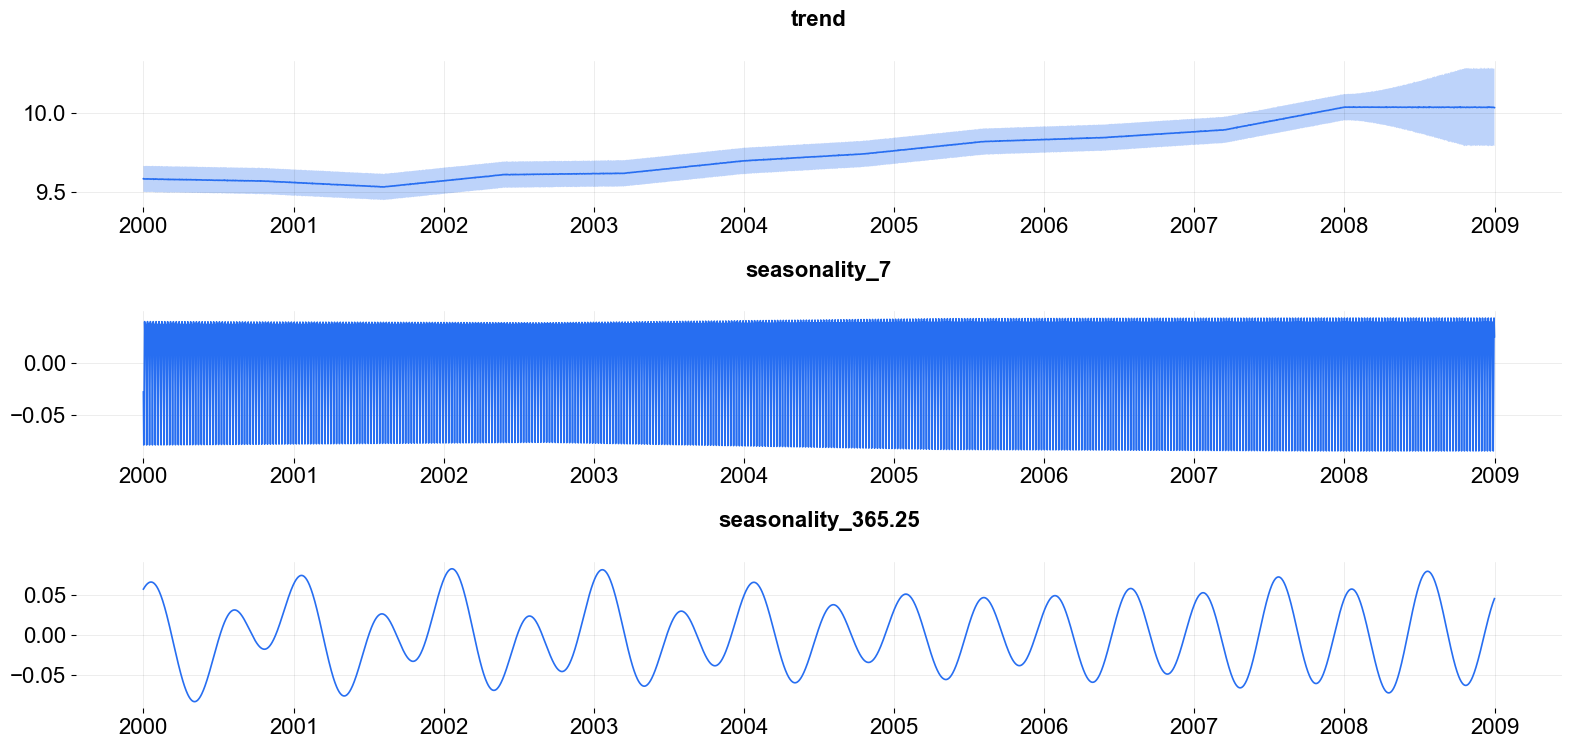

In [17]:
_ = plot_predicted_components(predicted_df=predicted_df, date_col=date_col, plot_components=['trend', 'seasonality_7', 'seasonality_365.25'])

## References

1. Ng, Wang and Dai (2021) Bayesian Time Varying Coefficient Model with Applications to Marketing Mix Modeling, arXiv preprint arXiv:2106.03322 
2. Hastie, Trevor and Tibshirani, Robert. (1990), Generalized Additive Models, New York: Chapman and Hall.
3. Wood, S. N. (2006), Generalized Additive Models: an introduction with R, Boca Raton: Chapman & Hall/CRC
4. Harvey, C. A. (1989). Forecasting, Structural Time Series and the Kalman Filter, Cambridge University Press.
5. Durbin, J., Koopman, S. J.. (2001). Time Series Analysis by State Space Methods, Oxford Statistical Science Series